In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import grad
from torch.distributions.multivariate_normal import MultivariateNormal
from copy import deepcopy
import time
from collections import OrderedDict
from tqdm import tqdm_notebook as tqdm
import matplotlib.pyplot as plt
import random

import seaborn as sns
sns.set()

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

torch.manual_seed(456)
np.random.seed(456)
random.seed(456)

# Utils

In [21]:
def generate_batch(batchlen, plot=False):
    cov = torch.tensor(np.identity(2) * 0.01, dtype=torch.float64)
    mu1 = torch.tensor([2 ** (-1 / 2), 2 ** (-1 / 2)], dtype=torch.float64)
    mu2 = torch.tensor([0, 1], dtype=torch.float64)

    gaussian1 = MultivariateNormal(loc=mu1, covariance_matrix=cov)
    gaussian2 = MultivariateNormal(loc=mu2, covariance_matrix=cov)

    d1 = gaussian1.rsample((int(batchlen / 2),))
    d2 = gaussian2.rsample((int(batchlen / 2),))

    data = np.concatenate((d1, d2), axis=0)
    np.random.shuffle(data)

    if plot:
        plt.scatter(data[:, 0], data[:, 1], s=2.0, color='gray')
        plt.show()
    return torch.Tensor(data).to(device)


def visualise_single(real_batch, fake_batch, filename=None, fake_color='cyan'):
    fig, ax = plt.subplots(1,1, figsize=(5,5))
    ax.scatter(real_batch[:, 0].cpu(), real_batch[:, 1].cpu(), s=2.0, label='real data', color='midnightblue')
    ax.scatter(fake_batch[:, 0].cpu(), fake_batch[:, 1].cpu(), s=2.0, label='fake data', color=fake_color)
    ax.legend(loc='upper left')
    ax.set_xlim(-1.5, 2.)
    ax.set_ylim(-1., 2.5)
    ax.tick_params(axis='both', which='major', labelsize=12)
    ax.locator_params('x', nbins=4)
    ax.locator_params('y', nbins=4)
    plt.show()
    if filename is not None:
        fig.savefig(filename, dpi=300, bbox_inches='tight')

    plt.close(fig)

    return fake_batch

def visualise_all(real_batch, all_fake_batches, filename=None):
    n_algorithms = len(all_fake_batches.keys())
    n_graphs_per_alg = len(all_fake_batches[list(all_fake_batches.keys())[0]].keys())
    legends = []

    n_rows = n_algorithms * 2
    n_cols = n_graphs_per_alg // 2
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(4 * n_cols + 8, 4 * n_rows))

    for i in range(n_rows):

        alg_name = list(all_fake_batches.keys())[i // n_algorithms]

        for j in range(n_cols):

            title, data = list(all_fake_batches[alg_name].items())[(i % n_algorithms) * n_cols + j]

            if alg_name == 'CGO':
                alg_color = 'cyan'
            elif alg_name == 'CGD':
                alg_color = 'brown'
            else:
                raise NotImplemented

            axes[i, j].set_aspect(aspect=1.)
            axes[i, j].scatter(real_batch[:, 0].cpu(), real_batch[:, 1].cpu(), s=2.0, label='real data', color='midnightblue')
            axes[i, j].scatter(data[:, 0].cpu(), data[:, 1].cpu(), s=2.0, label=alg_name, color=alg_color)
            axes[i, j].set_xlim(-0.75, 1.25)
            axes[i, j].set_ylim(-0.25, 1.75)
            axes[i, j].set_title(title, fontsize=12, pad=0)
            axes[i, j].tick_params(axis='both', which='major', labelsize=8)
            axes[i, j].set_yticklabels([])
            axes[i, j].set_xticklabels([])
            axes[i, j].locator_params('x', nbins=4)
            axes[i, j].locator_params('y', nbins=4)
            if j == n_cols-1 and (i % n_algorithms) == 0:
                legends.append(axes[i, j].legend(loc='upper center', bbox_to_anchor=(1.6, 1.), fancybox=True, ncol=1, prop={'size': 16}))

    fig.tight_layout()

    for legend in legends:
        for handle in legend.legendHandles:
            handle.set_sizes([40.0])

    plt.show()
    if filename is not None:
        fig.savefig(filename, dpi=300, bbox_inches='tight', bbox_extra_artists=legends)

    plt.close(fig)

# Models

In [22]:
# Define the generator
class Generator(nn.Module):
    def __init__(self, hidden_size=0, noise_size=1, noise_std=1.):
        super().__init__()
        self.noise_size = noise_size
        self.noise_std = noise_std

        self.fc1 = nn.Linear(noise_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.fc3 = nn.Linear(hidden_size, hidden_size)
        self.fc4 = nn.Linear(hidden_size, hidden_size)
        self.fc5 = nn.Linear(hidden_size, hidden_size)

        self.fc6 = nn.Linear(hidden_size, 2)

    def __call__(self, z):
        h = F.relu(self.fc1(z))

        h = F.relu(self.fc2(h))
        h = F.relu(self.fc3(h))
        h = F.relu(self.fc4(h))
        h = F.relu(self.fc5(h))

        return self.fc6(h)

    def generate(self, batchlen):
        z = torch.normal(torch.zeros(batchlen, self.noise_size), self.noise_std).to(device)
        return self.__call__(z)


# Define the discriminator
class Discriminator(nn.Module):
    def __init__(self, hidden_size=0):
        super().__init__()

        self.fc1 = nn.Linear(2, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.fc3 = nn.Linear(hidden_size, hidden_size)
        self.fc4 = nn.Linear(hidden_size, hidden_size)
        self.fc5 = nn.Linear(hidden_size, hidden_size)
        self.fc6 = nn.Linear(hidden_size, 1)

    def __call__(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = F.relu(self.fc4(x))
        x = F.relu(self.fc5(x))
        return self.fc6(x)


def GAN(eta, TRAIN_RATIO=1, N_ITER=250, BATCHLEN=128, hidden_size_G=0, hidden_size_D=0, noise_size=1, noise_std=1., frame=1000, alpha = 0.1, show=True):
    """
    TRAIN_RATIO : int, number of times to train the discriminator between two generator steps
    N_ITER : int, total number of training iterations for the generator
    BATCHLEN : int, Batch size to use
    hidden_size_G : int, width of the generator (number of neurons in hidden layers)
    hidden_size_D : int, width of the discriminator (number of neurons in hidden layers)
    noise_size : int, dimension of input noise
    noise_std : float, standard deviation of p(z)
    frame : int, display data each 'frame' iteration
    """

    fixed_batch = generate_batch(1024)  # for visualisation purposes
    all_fake_batches = OrderedDict()

#     for alg in ['CGO', 'CGD']:
    for alg in ['CGO','CGD']:
        losses = []
        all_fake_batches[alg] = OrderedDict()

        if alg == 'CGO':
            pass

        elif alg == 'CGD':
            alpha = eta
        else:
            raise NotImplemented

        G = Generator(hidden_size=hidden_size_G, noise_size=noise_size, noise_std=noise_std).to(device)
        D = Discriminator(hidden_size=hidden_size_D).to(device)

        D_optimiser = torch.optim.SGD(G.parameters(), lr=eta)
        G_optimiser = torch.optim.SGD(D.parameters(), lr=eta)

        criterion = nn.BCEWithLogitsLoss()
        print(eta)
        print(alpha)
        for i in tqdm(range(N_ITER+1)):

            # visualization
            if i % frame == 0:
                print(f"Iteration {i}")

                with torch.no_grad():
                    all_fake_batches[alg][f'Iteration {i}'] = G.generate(1024)

                if show:
                    pass
                    visualise_single(real_batch=fixed_batch, fake_batch=all_fake_batches[alg][f'Iteration {i}'],
                                     fake_color='cyan' if alg == "CGO" else "brown")

            # train the discriminator
            real_batch = generate_batch(BATCHLEN)
            fake_batch = G.generate(BATCHLEN).to(device)

            # Compute here the total loss
            h_real = D(real_batch)
            h_fake = D(fake_batch)

            loss_real = criterion(h_real, torch.ones((BATCHLEN, 1)).to(device))
            loss_fake = criterion(h_fake, torch.zeros((BATCHLEN, 1)).to(device))

            total_loss = loss_real + loss_fake
            losses.append(total_loss)
            # Compute the update for both agents
            D_update, G_update = compute_cgo_update(f=total_loss,
                                                g=-total_loss,
                                                x=list(D.parameters()),
                                                y=list(G.parameters()),
                                                alpha=alpha)  # real learning rate

            with torch.no_grad():

                # Apply the update
                for p, update in zip(D.parameters(), D_update):
                    p.grad = update

                for p, update in zip(G.parameters(), G_update):
                    p.grad = update
            
            G_optimiser.step()
            D_optimiser.step()
        plt.plot(losses)
    visualise_all(real_batch=fixed_batch, all_fake_batches=all_fake_batches, filename="Experiment2_GAN_GM")

# CGO and CGD updates

In [23]:
def compute_gda_update(f, x, g, y, eta=None):
    """
    Computes the gradient step for both players
    f: loss function to minimise for player X
    x: current action (parameters) of player X
    g: loss function to minimise for player Y
    y: current action (parameters) of player y
    """
    x_update = list(grad(outputs=f, inputs=x, retain_graph=True))
    y_update = list(grad(outputs=g, inputs=y))

    return x_update, y_update

def compute_cgo_update(f, x, g, y, alpha, max_it=10):
    """
    Iteratively estimate the solution for the local Nash equilibrium using the conjugate gradient method
    f: loss function to minimise for player X
    x: current action (parameters) of player X
    g: loss function to minimise for player Y
    y: current action (parameters) of player y
    """
    start = time.time()

    # Computing the gradients

    df_dx = grad(outputs=f, inputs=x, create_graph=True, retain_graph=True)
    dg_dy = grad(outputs=g, inputs=y, create_graph=True, retain_graph=True)

    df_dy = grad(outputs=f, inputs=y, create_graph=True, retain_graph=True)
    dg_dx = grad(outputs=g, inputs=x, create_graph=True, retain_graph=True)

    with torch.no_grad():

        # Creating the appropriate structure for the parameter updates and initialising to 0

        x_update, y_update = [], []
        for x_grad_group, y_grad_group in zip(df_dx, dg_dy):
            x_update.append(torch.zeros_like(x_grad_group))
            y_update.append(torch.zeros_like(y_grad_group))

        # Creating the appropriate structure for the residuals and basis vectors and initialise them

        r_xk, r_yk, p_xk, p_yk = [], [], [], []
        for x_param_update, y_param_update in zip(df_dx, dg_dy):
            r_xk.append(torch.clone(x_param_update))
            p_xk.append(torch.clone(x_param_update))
            r_yk.append(torch.clone(y_param_update))
            p_yk.append(torch.clone(y_param_update))

    # Iteratively solve for the local Nash Equilibrium

    for k in range(max_it):

        # Computes the Hessian-vector product Ap

        hvp_x = grad(outputs=df_dy, inputs=x, grad_outputs=p_yk, retain_graph=True)
        hvp_y = grad(outputs=dg_dx, inputs=y, grad_outputs=p_xk, retain_graph=True)

        with torch.no_grad():

            # Computes the matrix-basisVector product Ap

            Ap_x, Ap_y = [], []
            for i in range(len(p_xk)):
                Ap_x.append(p_xk[i] + alpha * hvp_x[i])
                Ap_y.append(p_yk[i] + alpha * hvp_y[i])

            # Computes step size alpha_k

            num, denom = 0., 0.
            for i in range(len(r_xk)):

                r_k_i = torch.cat([r_xk[i].flatten(), r_yk[i].flatten()])
                num += torch.dot(r_k_i, r_k_i)

                Ap_i = torch.cat([Ap_x[i].flatten(), Ap_y[i].flatten()])
                p_k_i = torch.cat([p_xk[i].flatten(), p_yk[i].flatten()])

                denom += torch.dot(p_k_i, Ap_i)

            alpha_k = num / denom

            # Computes new updates

            for i in range(len(x_update)):
                x_update[i] += alpha_k * p_xk[i]
                y_update[i] += alpha_k * p_yk[i]

            # Computes new residuals

            r_xkplus1, r_ykplus1 = [], []
            for i in range(len(r_xk)):
                r_xkplus1.append(r_xk[i] - alpha_k * Ap_x[i])
                r_ykplus1.append(r_yk[i] - alpha_k * Ap_y[i])

            # Check convergence condition

            r_xkplus1_squared_sum, r_ykplus1_squared_sum = 0., 0.
            x_update_squared_norm, y_update_squared_norm = 0., 0.
            for i in range(len(r_xkplus1)):
                r_xkplus1_squared_sum += torch.sum(r_xkplus1[i] ** 2.)
                r_ykplus1_squared_sum += torch.sum(r_ykplus1[i] ** 2.)

                x_update_squared_norm += torch.sum(x_update[i] ** 2.)
                y_update_squared_norm += torch.sum(y_update[i] ** 2.)

            r_kplus1_norm = torch.sqrt(r_xkplus1_squared_sum + r_ykplus1_squared_sum)
            update_norm = torch.sqrt(x_update_squared_norm + y_update_squared_norm)

            if r_kplus1_norm <= 1e-6:
                break

            else:

                # Computes beta_k

                num, denom = 0., 0.
                for i in range(len(r_xk)):
                    r_kplus1_i = torch.cat([r_xkplus1[i].flatten(), r_ykplus1[i].flatten()])
                    denom += torch.dot(r_kplus1_i, r_kplus1_i)

                    r_k_i = torch.cat([r_xk[i].flatten(), r_yk[i].flatten()])
                    denom += torch.dot(r_k_i, r_k_i)

                beta_k = num / denom

                # Computes new basis vectors

                for i in range(len(p_xk)):
                    p_xk[i] = r_xkplus1[i] + beta_k * p_xk[i]
                    p_yk[i] = r_ykplus1[i] + beta_k * p_yk[i]

                r_xk = deepcopy(r_xkplus1)
                r_yk = deepcopy(r_ykplus1)
    
    return x_update, y_update

# Main()

0.025
0.1


Iteration 0


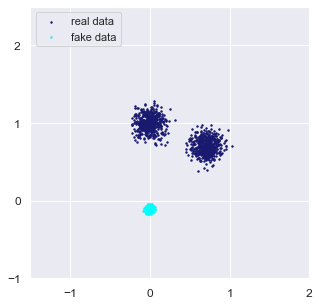

Iteration 250


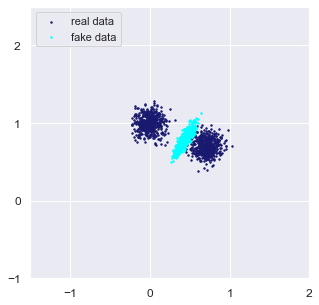

Iteration 500


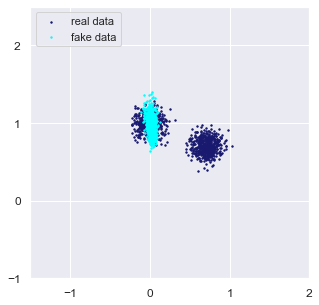

Iteration 750


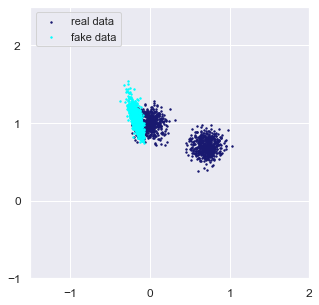

Iteration 1000


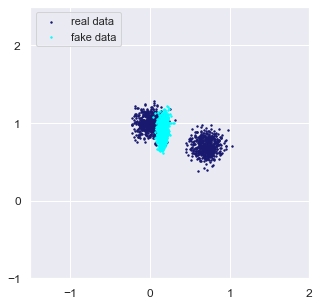

Iteration 1250


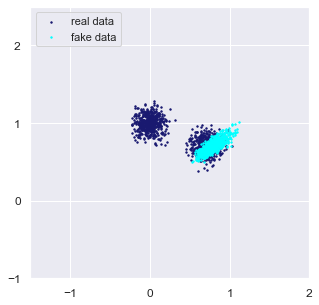

Iteration 1500


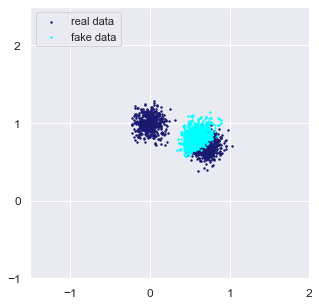

Iteration 1750


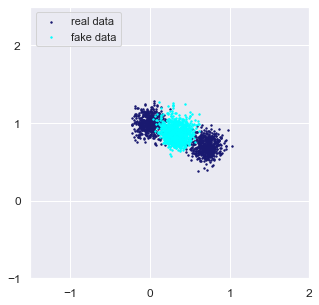

Iteration 2000


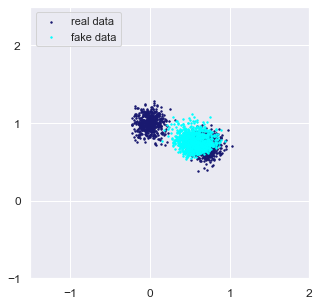

Iteration 2250


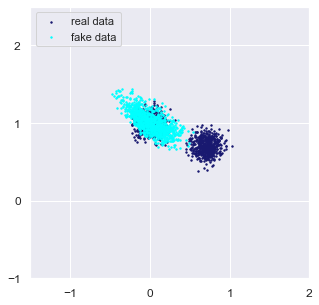

Iteration 2500


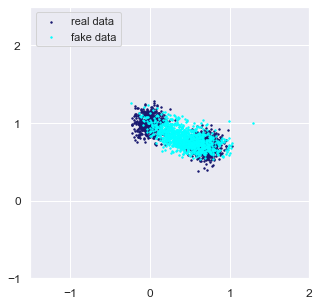


0.025
0.025


Iteration 0


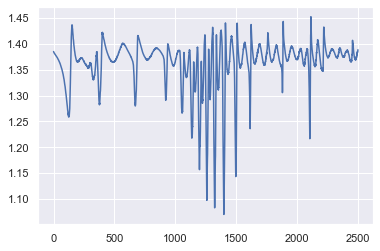

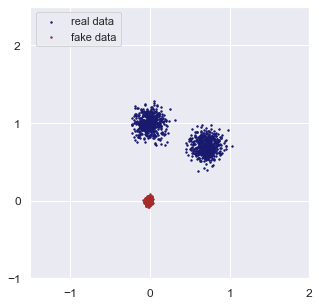

Iteration 250


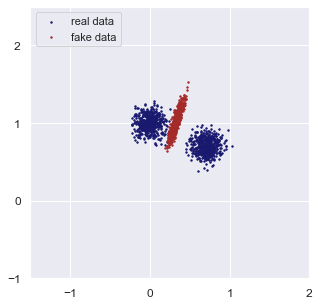

Iteration 500


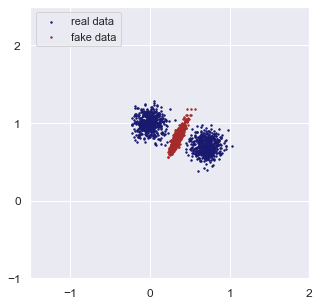

Iteration 750


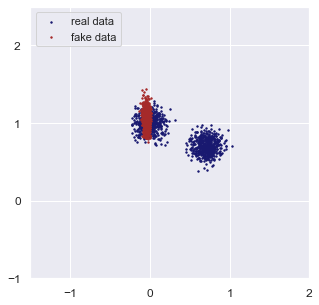

Iteration 1000


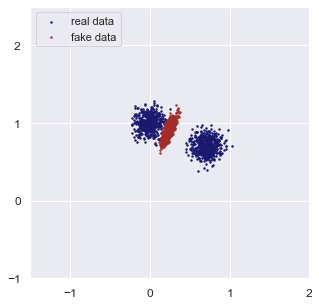

Iteration 1250


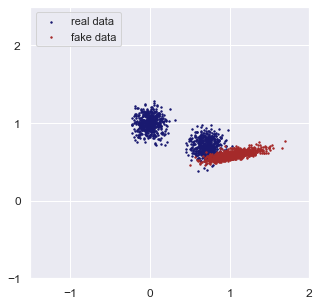

Iteration 1500


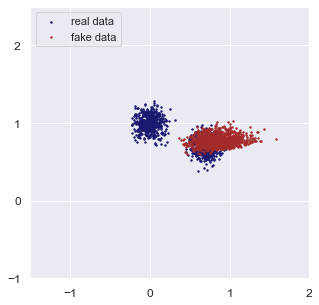

Iteration 1750


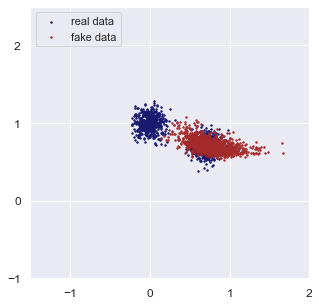

Iteration 2000


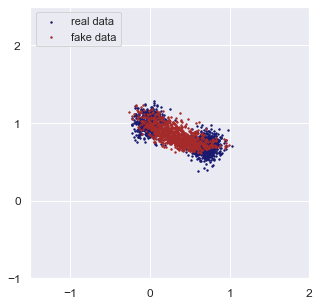

Iteration 2250


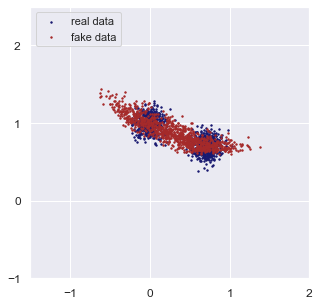

Iteration 2500


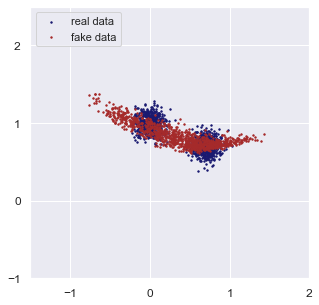

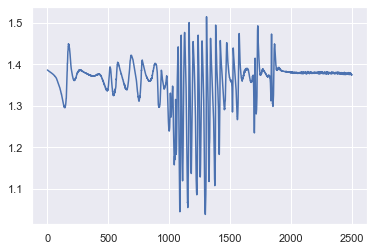

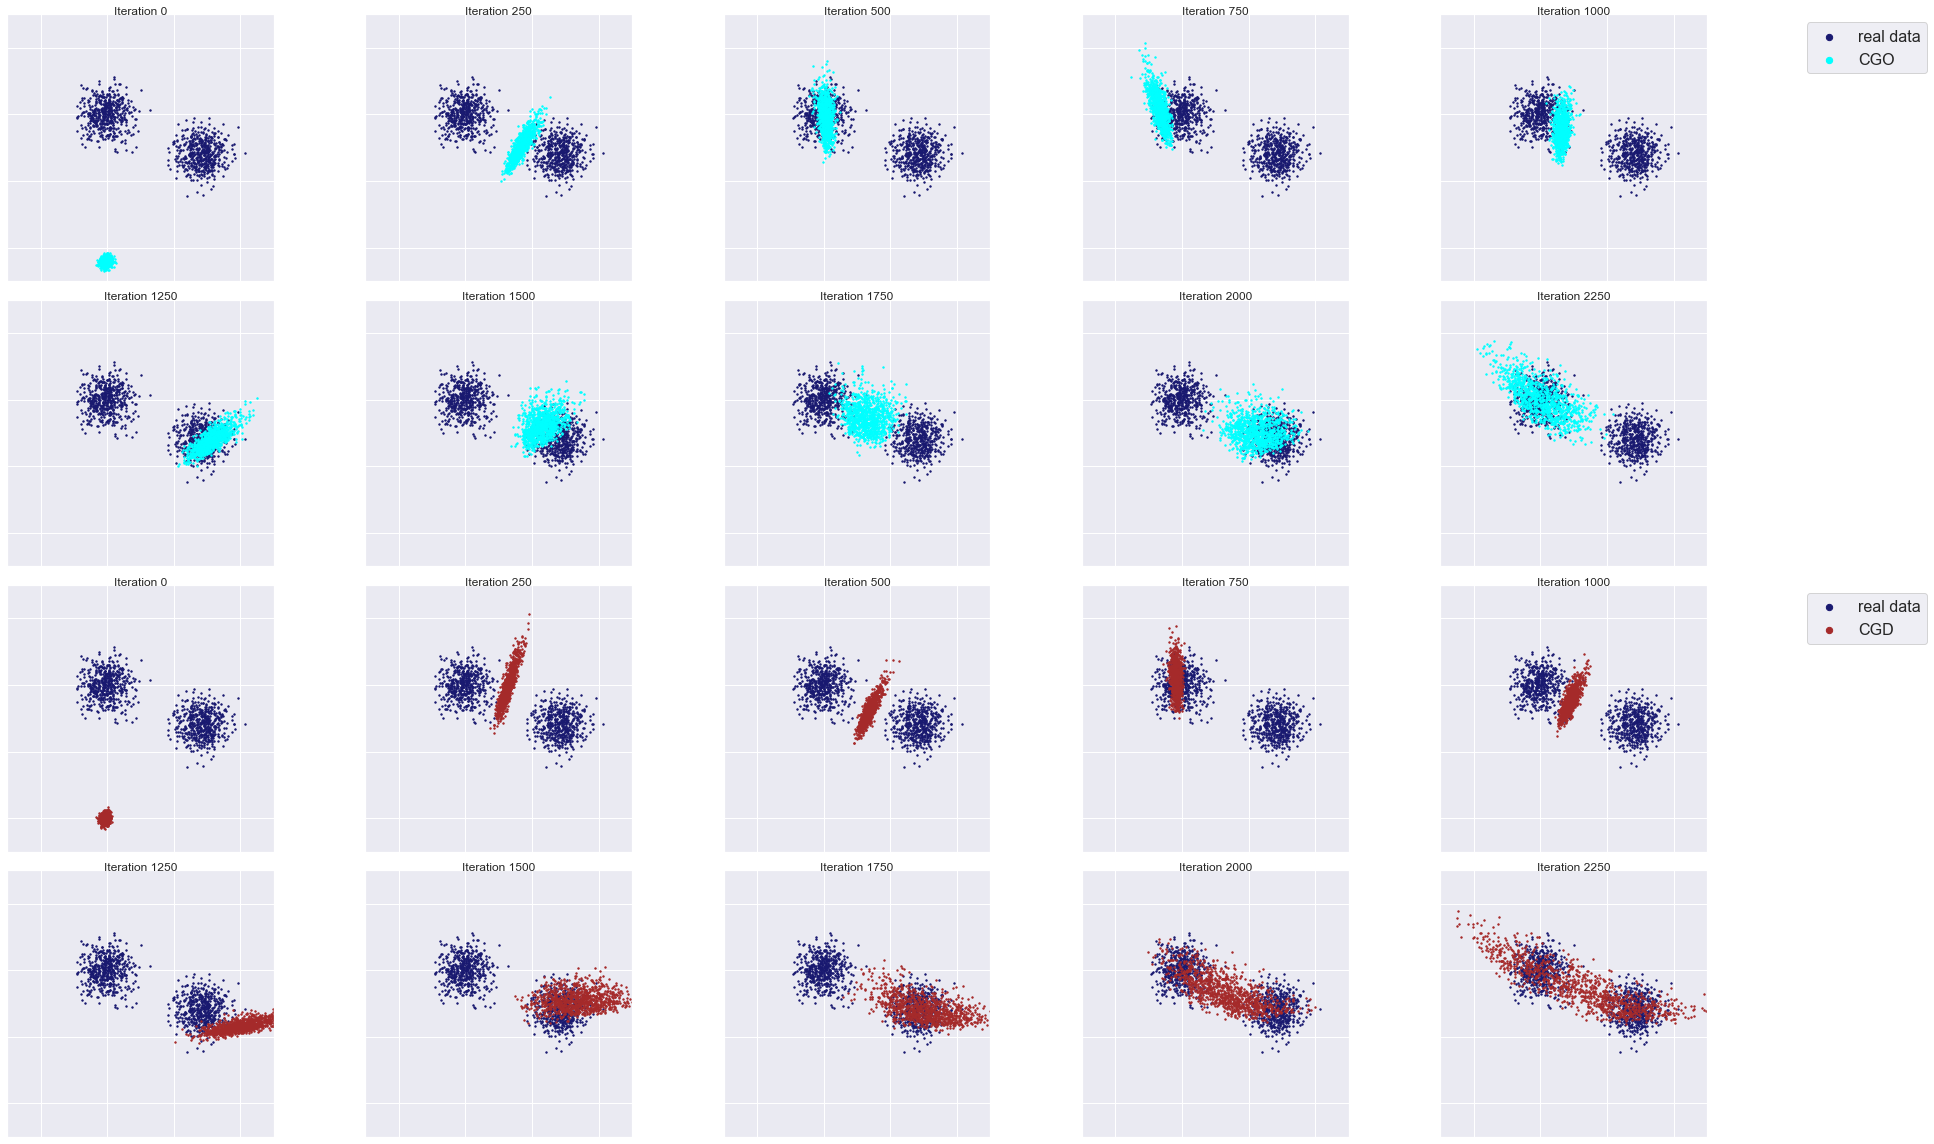

In [26]:
batch = generate_batch(256, plot=False)

GAN(TRAIN_RATIO=2,
    N_ITER=2500,
    BATCHLEN=128,
    hidden_size_G=128,
    hidden_size_D=128,
    noise_size=512,
    noise_std=6,
    frame=250,
    eta=0.025,
    show=True)